In [2]:
import pyswmm
import re
from swmm.toolkit.shared_enum import LinkAttribute,NodeAttribute
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [9]:
 # Replace with appropriate path and filename
directory='C:/IWS_Modelling/Other SWMM Trials/Mohan and Abhi Undulating/'
filename='Mohan_Abhijith_Net2_3O2S1P_hotstarted.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename


# sim=pyswmm.Simulation(inputfile=abs_path, outputfile=directory+name_only+".out")

# stp=0       #steps counter
# every=10000  #Interval of printing current time

# # runs the simulation step by step
# with sim as sim:
#     for step in sim:
#         if stp%every==0:
#             print('Current Time is >> ',sim.current_time)
#         stp+=1
#         pass

sim=pyswmm.Simulation(inputfile=abs_path, outputfile=directory+name_only+".out")

links=pyswmm.links.Links(sim)   #object containing links in the network model
nodes=pyswmm.nodes.Nodes(sim)


link_flowrates=pd.DataFrame()  #Empty Dataframe to store demand rates
link_volumes=pd.DataFrame()  #Empty Dataframe to store demand rates
node_volumes=pd.DataFrame()

# Reads the output file created above
with pyswmm.Output(directory+name_only+".out") as out:
    # loops through each link in output file
    for link in out.links:
        # Demand Flow Rates to calculate Volume Used by Consumers
        if re.search("^Demand",link):
            link_flowrates.loc[:,link]=out.link_series(link,LinkAttribute.FLOW_RATE).values()
        # Volume in Network Pipes
        elif re.search("^P",link):
            link_volumes.loc[:,link]=out.link_series(link,LinkAttribute.FLOW_VOLUME).values()
    for node in out.nodes:
        # Volume in Consumer Storage Units
        if re.search("^Storage",node) or re.search("^Overflow",node):
            node_volumes.loc[:,node]=out.node_series(node,NodeAttribute.PONDED_VOLUME).values()
        # Volume in Source Reervoir
        elif re.search("^1$",node):
            reservoir=list(out.node_series(node,NodeAttribute.PONDED_VOLUME).values())
sim.close()
pyswmm.Output.close

Selected File:  Mohan_Abhijith_Net2_3O2S1P_hotstarted


<function pyswmm.output.Output.close(self) -> bool>

In [10]:
brk=0
with pyswmm.Output(directory+name_only+".out") as out:
    for link in out.links:
        time=list(out.link_series(link,LinkAttribute.FLOW_RATE).keys())
        brk=1
        if brk==1:
            break
pyswmm.Output.close
reporting_step=(time[1]-time[0]).seconds
time = [(x-time[0]).seconds/3600 for x in time]

<function matplotlib.pyplot.show(close=None, block=None)>

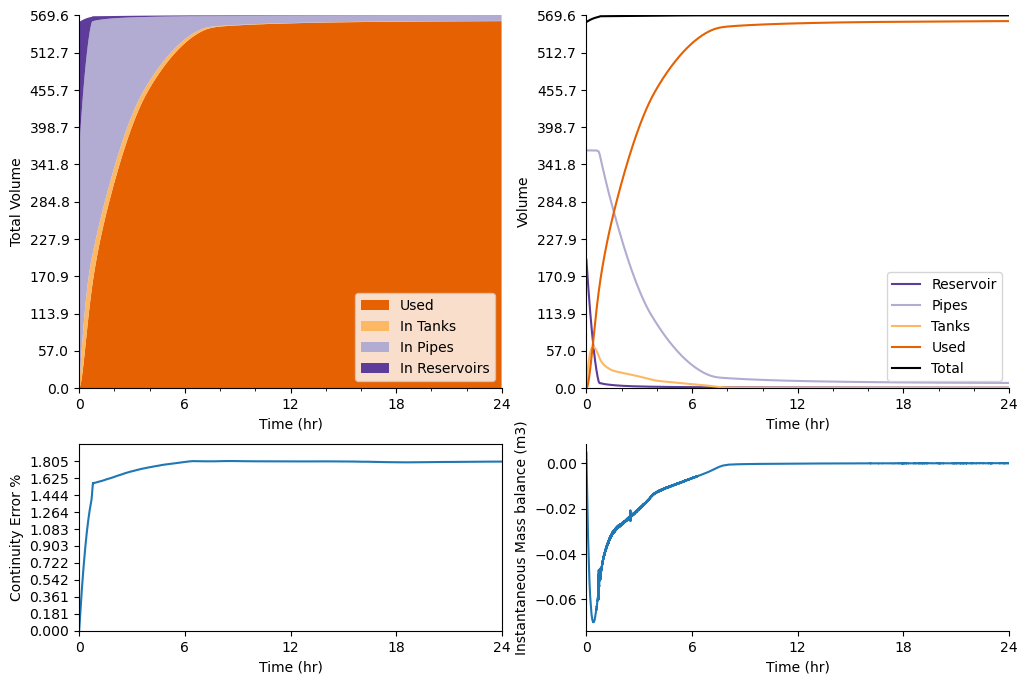

In [11]:
volume_used=(link_flowrates.sum(axis=1)*reporting_step/1000).cumsum()
volume_stored=node_volumes.sum(axis=1)
volume_network=link_volumes.sum(axis=1)
volume_source=reservoir
volume_total=volume_used+volume_network+volume_stored+volume_source
base_volume=volume_total[0]
cont_error=(volume_total-base_volume)/base_volume*100
water_balance=pd.DataFrame(zip(time,volume_source,volume_network,volume_stored,volume_used,volume_total),columns=["Time","Reservoirs","Network","Storage","Used","Total"])

y=np.vstack([water_balance["Used"],water_balance["Storage"],water_balance["Network"],water_balance["Reservoirs"]])
fig, ax=plt.subplots(2,2,sharex=False,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0,0].stackplot(water_balance["Time"],y,labels=["Used","In Tanks","In Pipes","In Reservoirs"],colors=["#e66101","#fdb863","#b2abd2","#5e3c99"])
ax[0,0].set_xlim(0,max(water_balance["Time"]))
ax[0,0].set_xlabel("Time (hr)")
ax[0,0].set_ylabel("Total Volume")
ax[0,0].set_xticks(np.arange(0,max(water_balance["Time"])*1.01,round((max(water_balance["Time"]))/4,2)))
ax[0,0].set_xticks(np.arange(0,max(water_balance["Time"])*1.01,round((max(water_balance["Time"]))/12,2)),minor=True)
ax[0,0].set_yticks(np.arange(0,max(water_balance["Total"])+1,max(water_balance["Total"])/10))
ax[0,0].set_ylim(0,max(water_balance["Total"])+1)
ax[0,0].legend(loc="lower right")
ax[0,0].spines[['right', 'top']].set_visible(False)


ax[1,0].plot(water_balance["Time"],cont_error)
ax[1,0].set_xlim(0,max(water_balance["Time"]))
ax[1,0].set_xlabel("Time (hr)")
ax[1,0].set_ylabel("Continuity Error %")
ax[1,0].set_xticks(np.arange(0,max(water_balance["Time"])*1.1,round((max(water_balance["Time"]))/4,2)))
ax[1,0].set_yticks(np.arange(min(cont_error),max(cont_error)*1.1,max(cont_error)/10))
ax[1,0].set_ylim(min(cont_error),max(cont_error)*1.1)

line1,=ax[0,1].plot(water_balance["Time"],water_balance["Reservoirs"],label="Reservoir",color="#5e3c99")
line2,=ax[0,1].plot(water_balance["Time"],water_balance["Network"],label="Pipes",color="#b2abd2")
line3,=ax[0,1].plot(water_balance["Time"],water_balance["Storage"],label="Tanks",color="#fdb863")
line4,=ax[0,1].plot(water_balance["Time"],water_balance["Used"],label="Used",color="#e66101")
line5,=ax[0,1].plot(water_balance["Time"],water_balance["Total"],label="Total",color='black')

ax[0,1].set_xlim(0,max(water_balance["Time"]))
ax[0,1].set_xlabel("Time (hr)")
ax[0,1].set_ylabel("Volume")
ax[0,1].set_xticks(np.arange(0,max(water_balance["Time"])*1.01,round((max(water_balance["Time"]))/4,2)))
ax[0,1].set_xticks(np.arange(0,max(water_balance["Time"])*1.01,round((max(water_balance["Time"]))/12,2)),minor=True)
ax[0,1].set_yticks(np.arange(0,max(water_balance["Total"])+1,max(water_balance["Total"])/10))
ax[0,1].set_ylim(min(cont_error),max(water_balance["Total"])+1)
ax[0,1].legend(loc="lower right")
ax[0,1].spines[['right', 'top']].set_visible(False)

diff=water_balance.diff().dropna()
diff["Time"]=water_balance["Time"]
line1,=ax[1,1].plot(diff["Time"],diff["Reservoirs"]+diff["Network"]+diff["Storage"])
# line2,=ax[0].plot(diff["Time"],diff["Network"],label="Pipes")
# line3,=ax[0].plot(diff["Time"],diff["Storage"],label="Tanks")

ax[1,1].set_xlim(0,max(diff["Time"]))
ax[1,1].set_xlabel("Time (hr)")
ax[1,1].set_ylabel("Instantaneous Mass balance (m3)")
ax[1,1].set_xticks(np.arange(0,max(diff["Time"])*1.1,round((max(diff["Time"]))/4,2)))
ax[1,1].spines[['right', 'top']].set_visible(False)


plt.show

[15418.87109375, 62.84844868991058, 0.0, 0.0, 0.0]

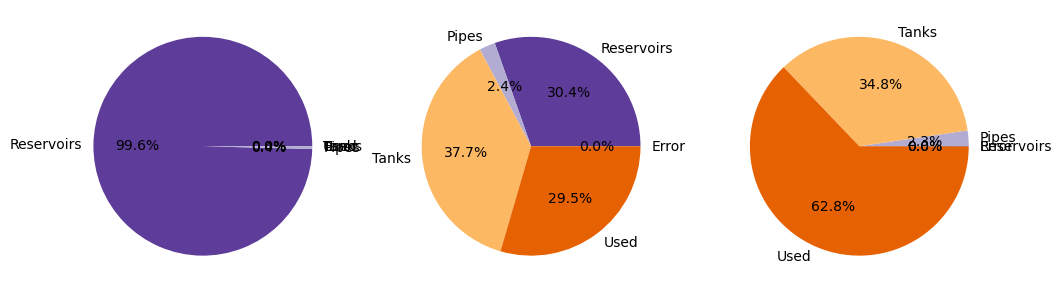

In [7]:
pie_chart_start=list(water_balance.iloc[0,1:-1])
pie_chart_start.append(cont_error.iloc[0])

pie_chart_mid=list(water_balance.iloc[int(round(len(water_balance.index)/2,0)),1:-1])

if cont_error.iloc[int(round(len(cont_error.index)/2,0))]>=0:
       pie_chart_mid.append(cont_error.iloc[int(round(len(cont_error.index)/2,0))])
else: pie_chart_mid.append(0)


pie_chart_end=list(water_balance.iloc[-1,1:-1])
pie_chart_end.append(cont_error.iloc[-1])
fig,ax=plt.subplots(1,3)
fig.set_figwidth(12)

ax[0].pie(pie_chart_start,labels=["Reservoirs","Pipes","Tanks","Used","Error"],
       colors=["#5e3c99","#b2abd2","#fdb863","#e66101","black"],autopct="%1.1f%%")
ax[1].pie(pie_chart_mid,labels=["Reservoirs","Pipes","Tanks","Used","Error"],
       colors=["#5e3c99","#b2abd2","#fdb863","#e66101","black"],autopct="%1.1f%%")
ax[2].pie(pie_chart_end,labels=["Reservoirs","Pipes","Tanks","Used","Error"],
       colors=["#5e3c99","#b2abd2","#fdb863","#e66101","black"],autopct="%1.1f%%")
plt.show
pie_chart_start

[0.06281019002199173,
 52.88804248558972,
 5819.52509650588,
 9558.896534624277,
 0.07656385408336974]

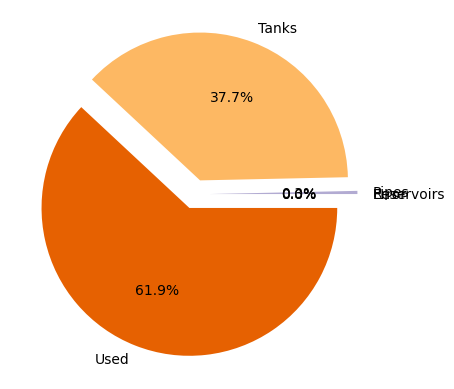

In [32]:
pie_chart=list(water_balance.iloc[-1,1:-1])
pie_chart.append(cont_error.iloc[-1])
fig,ax=plt.subplots()

ax.pie(pie_chart,labels=["Reservoirs","Pipes","Tanks","Used","Error"],
       colors=["#5e3c99","#b2abd2","#fdb863","#e66101","black"],explode=[0.1,.1,.1,.1,.1],autopct="%1.1f%%")
plt.show
pie_chart

<function matplotlib.pyplot.show(close=None, block=None)>

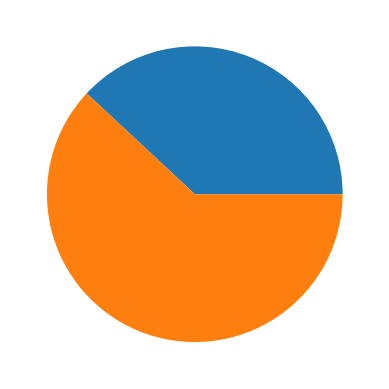

In [33]:
pie_chart=list()
pie_chart.append(sum(water_balance.iloc[-1,1:-2]))
pie_chart.append(water_balance.iloc[-1,-2])
pie_chart.append(cont_error.iloc[-1])
fig,ax=plt.subplots()
ax.pie(pie_chart)
plt.show

In [8]:
water_balance.to_csv(directory+name_only+"WaterBalance.csv")